## Event Detection 

In [1]:
import pandas as pd
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
sys.path.append('../../')

from scoring.event_detection_matrix import competition_score
from tqdm import tqdm

## Daten laden

In [2]:
predictions = pd.read_parquet('./data/predicted_series_mlp_lag_features.parquet')
validation_events = pd.read_csv('../../data/processed/validation_events_split.csv')

In [3]:
validation_events = validation_events[validation_events.step.notnull()]

In [4]:
predictions['series_id'] = predictions['num_series_id'].astype(str)

In [5]:
predictions['correct_prediction'] = (predictions['awake'] == predictions['prediction_class']).replace({True: 1, False: 0})

## Extract Events

In [6]:
def get_events_smoothed(test_series) :
    series_ids = test_series['num_series_id'].unique()
    events = []

    for idx in tqdm(series_ids):
        # Collecting sample and normalizing features
        X = test_series[test_series.num_series_id == idx]
                
        smoothing_length = 12 * 60 # 30 Minutes
        # We average the confidence, that the participant is awake
        X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
        X["asleep"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()

        # Binarize the asleep column
        X["asleep"] = X["asleep"].round()

        # Getting predicted onset and wakeup time steps
        pred_onsets = X[X['asleep'].diff() > 0]['step'].tolist() # diff is > 0 if it changes from 0 (awake) to 1 (asleep)
        pred_wakeups = X[X['asleep'].diff() < 0]['step'].tolist() # diff is < 0 if it changes from 1 (asleep) to 0 (awake)
     
        if len(pred_onsets) > 0:

            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets):
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups):
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods:
                # We take the score
                score = 1 - X[(X['step'] >= onset) & (X['step'] < wakeup)]['confidence_awake'].mean()

                # Adding sleep event to dataframe
                onset_row = {'row_id': len(events), 'series_id': idx, 'step': onset, 'event': 'onset', 'score': score}                
                events.append(onset_row)

                wakeup_row = {'row_id': len(events), 'series_id': idx, 'step': wakeup, 'event': 'wakeup', 'score': score}
                events.append(wakeup_row)

    return pd.DataFrame(events)

In [7]:
predicted_events = get_events_smoothed(predictions)

  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_106877/2624563889.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
/tmp/ipykernel_106877/2624563889.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["asleep"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()
/tmp/ipykernel_106877/2624563889.py:15: SettingWithCopyWarning: 
A value is trying

 67%|██████████████████████████████████████████████████████████▋                             | 36/54 [00:34<00:17,  1.05it/s]C:\Users\timon\AppData\Local\Temp\ipykernel_23456\466640144.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["score"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\timon\AppData\Local\Temp\ipykernel_23456\466640144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["smooth"] = X["prediction_confidence_0"].rolling(smooth

 78%|████████████████████████████████████████████████████████████████████▍                   | 42/54 [00:41<00:13,  1.14s/it]C:\Users\timon\AppData\Local\Temp\ipykernel_23456\466640144.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["score"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\timon\AppData\Local\Temp\ipykernel_23456\466640144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["smooth"] = X["prediction_confidence_0"].rolling(smooth

 89%|██████████████████████████████████████████████████████████████████████████████▏         | 48/54 [00:47<00:06,  1.09s/it]C:\Users\timon\AppData\Local\Temp\ipykernel_23456\466640144.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["score"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\timon\AppData\Local\Temp\ipykernel_23456\466640144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["smooth"] = X["prediction_confidence_0"].rolling(smooth

100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:53<00:00,  1.01it/s]


In [8]:
validation_events['series_id'] = validation_events['num_series_id']

In [9]:
competition_score(validation_events, predicted_events)

0.4246432915501572

## Daten visualisieren

In [10]:
sample = predictions[predictions.num_series_id == 7]

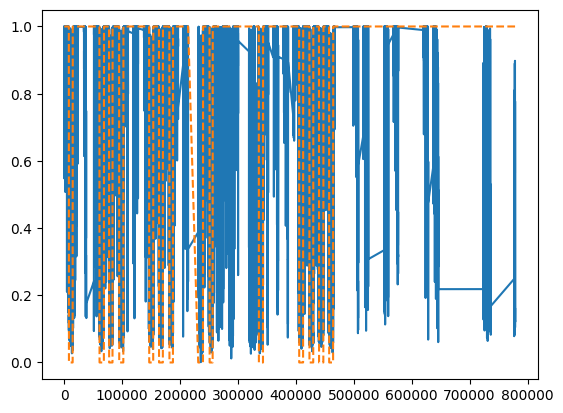

In [11]:
plt.plot(sample['step'], sample['prediction_confidence_1'])
plt.plot(sample['step'], sample['awake'], linestyle='dashed')
plt.show()

## Accuracy pro Serie

In [12]:
series = predictions.series_id.unique()

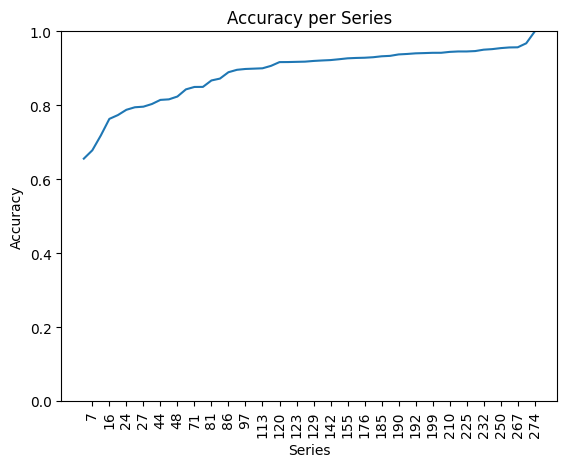

In [13]:
ax = predictions.groupby('series_id')['correct_prediction'].mean().sort_values().plot(
    ylim=(0, 1), title='Accuracy per Series'
)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Series")
ax.set_xticks(ticks=[*range(1, len(series), 2)], labels=series[::2], rotation=90)

fig = ax.get_figure()
fig.savefig("accuracy-per-series.png", bbox_inches="tight")

In [14]:
predictions.groupby('series_id')['correct_prediction'].mean().sort_values()

series_id
187    0.656007
179    0.678587
26     0.718741
71     0.763536
86     0.773816
171    0.788156
250    0.795008
217    0.796593
24     0.803773
122    0.814934
196    0.816417
27     0.824065
10     0.843423
83     0.849946
7      0.850134
267    0.867533
44     0.872578
117    0.889822
210    0.896346
232    0.898624
270    0.899506
191    0.900425
176    0.907012
248    0.917181
190    0.917340
124    0.917892
120    0.918424
16     0.920312
192    0.921603
48     0.922670
123    0.924928
185    0.927418
72     0.928423
204    0.928997
131    0.930358
113    0.932909
63     0.934081
251    0.937955
155    0.939212
81     0.940908
129    0.941579
199    0.942331
274    0.942395
148    0.944837
142    0.945973
97     0.945978
32     0.947049
108    0.950803
225    0.952298
21     0.955033
47     0.956836
276    0.957233
228    0.968056
94     1.000000
Name: correct_prediction, dtype: float64

## Competition Score pro Serie

In [15]:
series_ids = validation_events.series_id.unique()
scores = []

for series_id in tqdm(series_ids):
    predicted_events_series = predicted_events[predicted_events.series_id == series_id]
    true_events_series = validation_events[validation_events.series_id == series_id]

    if len(predicted_events_series) > 0:
        score = competition_score(true_events_series, predicted_events_series)
    else: 
        score = 0
        
    scores.append({'series_id': str(series_id), 'score': score})

scores = pd.DataFrame(scores)

100%|██████████| 54/54 [00:10<00:00,  5.20it/s]


In [16]:
scores = scores.sort_values('score')

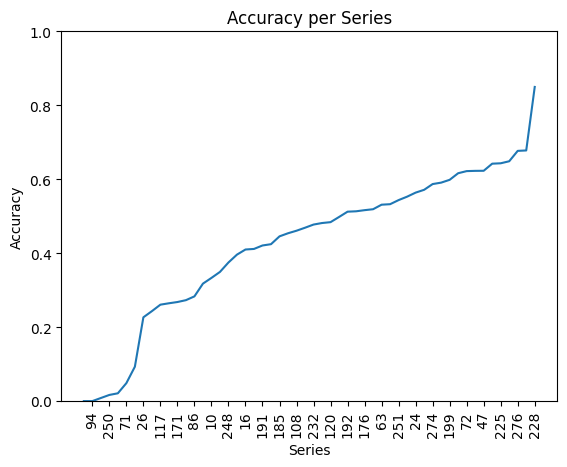

In [17]:
ax = scores.groupby('series_id')['score'].mean().sort_values().plot(
    ylim=(0, 1), title='Accuracy per Series'
)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Series")
ax.set_xticks(ticks=[*range(1, len(scores), 2)], labels=scores.series_id[::2], rotation=90)

fig = ax.get_figure()
fig.savefig("accuracy-per-series.png", bbox_inches="tight")

In [18]:
scores

series_id     score
17        94  0.000000
39       196  0.000000
48       250  0.008333
35       187  0.016667
12        71  0.021101
50       267  0.048569
5         26  0.093021
15        83  0.226702
21       117  0.243333
8         44  0.260906
31       171  0.264654
6         27  0.268048
16        86  0.273075
33       179  0.283333
1         10  0.317808
0          7  0.333293
47       248  0.349491
26       129  0.375015
2         16  0.396280
24       123  0.410136
37       191  0.411689
42       210  0.421033
34       185  0.424531
51       270  0.445720
19       108  0.454102
10        48  0.460986
46       232  0.469067
20       113  0.477637
22       120  0.481794
7         32  0.484152
38       192  0.498174
23       122  0.512500
32       176  0.513532
27       131  0.516584
11        63  0.519129
18        97  0.531404
49       251  0.532735
3         21  0.543841
4         24  0.553125
25       124  0.564063
52       274  0.571667
28       142  0.587213
40       199  0.591076
30       155  0.598706
13        72  0.616535
41       204  0.622243
9         47  0.622934
14        81  0.623160
44       225  0.642355
29       148  0.643432
53       276  0.648896
36       190  0.677038
45       228  0.678146
43       217  0.850000

## Daten visualisieren

In [29]:
participant_series_id = 228
participant_series = predictions[predictions.series_id == str(participant_series_id)]
participant_series = participant_series[0:100_000]

participant_events = predicted_events[predicted_events.series_id == participant_series_id]
participant_events = participant_events[0:12]

participant_true_events = validation_events[validation_events.series_id == participant_series_id]
participant_true_events = participant_true_events[0:12]

In [30]:
participant_series

num_series_id   step  awake  prediction_class  \
13662964            228      0      1                 1   
13662965            228      1      1                 1   
13662966            228      2      1                 1   
13662967            228      3      1                 1   
13662968            228      4      1                 1   
...                 ...    ...    ...               ...   
13762959            228  99995      1                 1   
13762960            228  99996      1                 1   
13762961            228  99997      1                 1   
13762962            228  99998      1                 1   
13762963            228  99999      1                 1   

          prediction_confidence_0  prediction_confidence_1 series_id  \
13662964             8.728079e-07                 0.999999       228   
13662965             5.615895e-08                 1.000000       228   
13662966             1.141291e-06                 0.999999       228   
13662967             8.494923e-07                 0.999999       228   
13662968             7.949060e-07                 0.999999       228   
...                           ...                      ...       ...   
13762959             2.581749e-03                 0.997418       228   
13762960             2.911021e-03                 0.997089       228   
13762961             9.165844e-04                 0.999083       228   
13762962             3.225813e-03                 0.996774       228   
13762963             1.003732e-03                 0.998996       228   

          correct_prediction  
13662964                   1  
13662965                   1  
13662966                   1  
13662967                   1  
13662968                   1  
...                      ...  
13762959                   1  
13762960                   1  
13762961                   1  
13762962                   1  
13762963                   1  

[100000 rows x 8 columns]

In [31]:
participant_true_events

series_id  night   event     step                 timestamp  \
2324        228      1   onset   2220.0  2017-11-09T22:05:00-0400   
2325        228      1  wakeup   8592.0  2017-11-10T06:56:00-0400   
2326        228      2   onset  19620.0  2017-11-10T22:15:00-0400   
2327        228      2  wakeup  26052.0  2017-11-11T07:11:00-0400   
2328        228      3   onset  37164.0  2017-11-11T22:37:00-0400   
2329        228      3  wakeup  43692.0  2017-11-12T06:41:00-0500   
2330        228      4   onset  54672.0  2017-11-12T21:56:00-0500   
2331        228      4  wakeup  60912.0  2017-11-13T06:36:00-0500   
2332        228      5   onset  72084.0  2017-11-13T22:07:00-0500   
2333        228      5  wakeup  78336.0  2017-11-14T06:48:00-0500   
2334        228      6   onset  89100.0  2017-11-14T21:45:00-0500   
2335        228      6  wakeup  95616.0  2017-11-15T06:48:00-0500   

      num_series_id  
2324            228  
2325            228  
2326            228  
2327            228  
2328            228  
2329            228  
2330            228  
2331            228  
2332            228  
2333            228  
2334            228  
2335            228

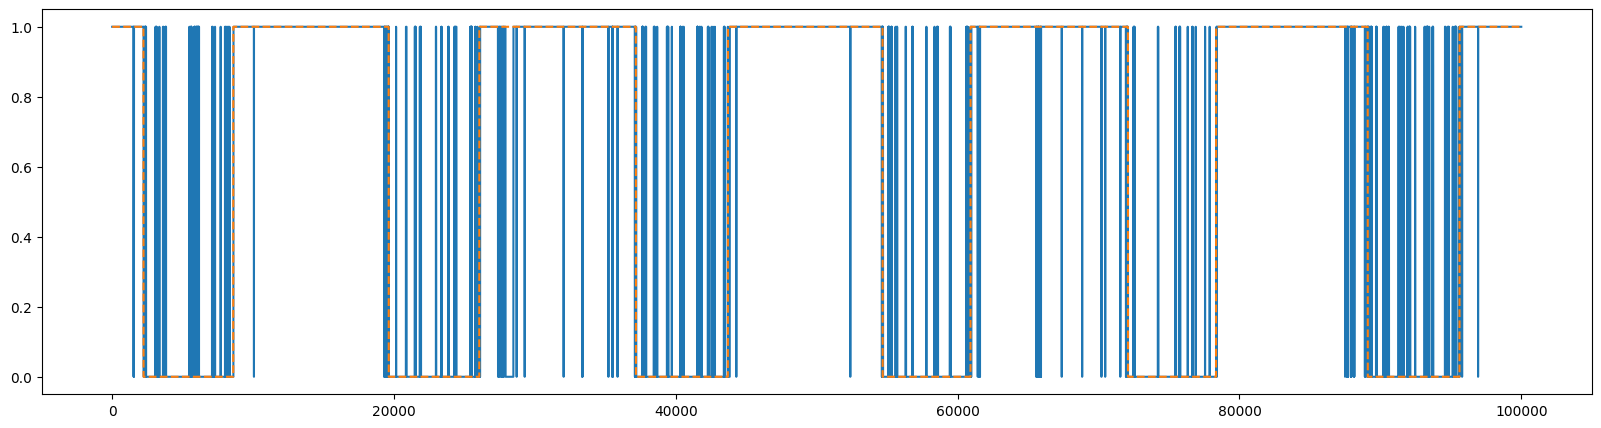

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(participant_series['step'], participant_series['prediction_class'])
plt.plot(participant_series['step'], participant_series['awake'], linestyle='dashed')
plt.show()

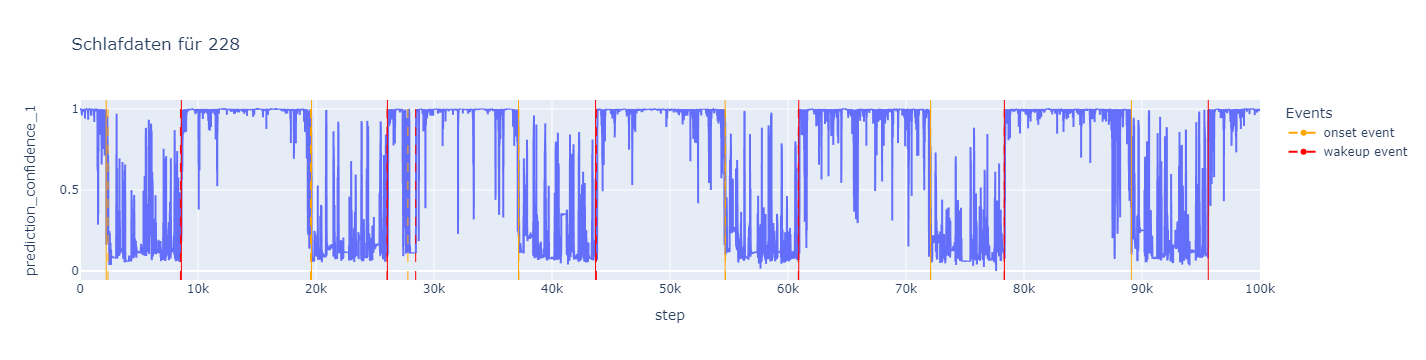

In [33]:
fig = px.line(participant_series, x='step', y='prediction_confidence_1', title=f'Schlafdaten für {participant_series_id}')
for index, row in participant_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_dash='dash', line_color=color)
    
for index, row in participant_true_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_color=color)

#Custom Legend
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='orange', width=2, dash='dash'),
        name="onset event",
    )
)
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='red', width=2, dash='dash'),
        name="wakeup event",
    )
)
fig.update_layout(legend_title="Events")
    
fig.show()